# Exercise Sheet 1



### Read the Dataset

- Use Pandas to read the 'covertype.csv' file
- The dataset contains information on different forest cover types
- Look at the columns. Which of them contain meaningful features?



### Seperate Features and Labels
- Define x as the vectors of meaningful features
- Define y as the labels (Cover_Type)



### Split the dataset into two disjoint datasets for training and testing
- Randomly split the dataset. Use 70% for training and 30% for testing.
- Define x_train and x_test as the feature vectors
- Define y_train and y_test as the labels
    - Hint: Have a look at the sklearn package

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('covertype.csv')
df = df.set_index('Id')

x = df.copy()

del x['Cover_Type']

y = df.Cover_Type

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)

### Train a simple deep neural network
- Use Pytorch to define a simple Multi-Layer Perceptron with at least 3 layers
    - The input layer should have as many neurons as there are features
        - How many features are there?
    - The last layer should have as many neurons as there are classes
        - How many classes are there?
- Pack your training and testing datasets in class which inherits from torch.utils.data.Datset
- Use a torch.utils.data.DataLoader to access your data in batches
- Train the MLP with your data from the train_loader using Cross-Entropy Loss and the Adam Optimizer
    - Make sure to save the training history for later assessment
- Evaluate the performance on your test_loader

In [2]:
import torch

# Define your MLP
class Net(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
# Create your DataLoaders
x_train_tensor, x_test_tensor = torch.Tensor(x_train.to_numpy()), torch.Tensor(x_test.to_numpy())
y_train_tensor, y_test_tensor = torch.Tensor(y_train.to_numpy()).long(), torch.Tensor(y_test.to_numpy()).long()

train_set = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_set = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)


In [4]:
# Instantiate the network, the optimizer and the Loss Criterion
input_size = x_train.shape[1]
num_classes = len(y.unique())

net = Net(input_size, num_classes)

optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.CrossEntropyLoss()



In [5]:
# Define your training Loop
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    correct = 0.
    samples = 0.
    for sample in dataloader:
        optimizer.zero_grad()
        data, label = sample
        prediction = model(data)
        loss = criterion(prediction, label)
        correct += sum(torch.argmax(prediction, dim=1) == label)
        samples += len(data)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
    return epoch_loss, correct/samples


# Define your testing Loop
def test_epoch(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0.
    samples = 0.
    for sample in dataloader:
        data, label = sample
        prediction = model(data)
        loss = criterion(prediction, label)
        correct += sum(torch.argmax(prediction, dim=1) == label)
        samples += len(data)
        epoch_loss += loss.data
    return epoch_loss, correct/samples
    


In [6]:
# Check if your training and testing loops are working
train_epoch(net, train_loader, criterion, optimizer)
test_epoch(net, train_loader, criterion)


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1570910687650/work/aten/src/THNN/generic/ClassNLLCriterion.c:97

### Debug
- If there is a RuntimeError raised in you loss function, either your network architecture or your data is faulty
    - Check your network architecture
    - Check your data
        - Are there any NaN or infinite features or labels?
    - Print the labels.
        - How many unique labels do you have?
        - Are they [0, ..., n-1]?
            - If not, align them

In [7]:
# Inspect your data
import numpy as np

print(np.isfinite(x.values).all())
print(np.isfinite(y.values).all())

print(sorted(y.unique()))

True
True
[1, 2, 3, 4, 5, 6, 7]


In [8]:
# Fix your data and recreate your DataLoaders

y = y-1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)

x_train_tensor, x_test_tensor = torch.Tensor(x_train.to_numpy()), torch.Tensor(x_test.to_numpy())
y_train_tensor, y_test_tensor = torch.Tensor(y_train.to_numpy()).long(), torch.Tensor(y_test.to_numpy()).long()

train_set = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_set = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)


### Train again
- Reinitialize your MLP from above and train it again

In [9]:
import tqdm

net = Net(input_size, num_classes)
optimizer = torch.optim.Adam(net.parameters())

train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

for i in tqdm.tnrange(100):
    loss, accuracy = train_epoch(net, train_loader, criterion, optimizer)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test_epoch(net, train_loader, criterion)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

    

### Does it work?
- There should not be a RuntimeError raised now
- Does the network converge / Does the loss decrease?


### Visualize the training
- use matplotlib.pyplot to visualize the history
- plot both the training accuracy and the validation accuracy
- Does the training stagnate?

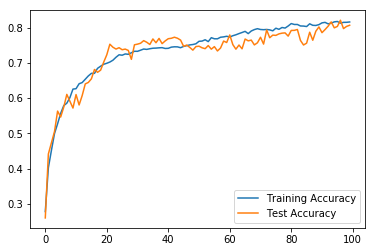

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")

plt.legend()
plt.show()


### Inspect the data
- Compute the min, max, mean and standard deviation of each feature
- What data type do the columns have?
- Use Pandas to print the statistics in a table
- What could be problematic with the dataset?

In [12]:
import numpy as np
pd.options.display.float_format = '{:.2f}'.format


stats = pd.DataFrame(columns=["Type", "Min", "Max", "Mean", "Std"])

for col in x.columns:
    stats.loc[col] = {"Type": x[col].dtype,
                      "Min": np.min(x[col]),
                      "Max": np.max(x[col]),
                      "Mean": np.mean(x[col]),
                      "Std": np.std(x[col])
                     }



display(stats)

,Type,Min,Max,Mean,Std
Elevation,int64,1863,3849,2749.32,417.66
Aspect,int64,0,360,156.68,110.08
Slope,int64,0,52,16.50,8.45
Horizontal_Distance_To_Hydrology,int64,0,1343,227.20,210.07
Vertical_Distance_To_Hydrology,int64,-146,554,51.08,61.24
Horizontal_Distance_To_Roadways,int64,0,6890,1714.02,1325.02
Hillshade_9am,int64,0,254,212.70,30.56
Hillshade_Noon,int64,99,254,218.97,22.80
Hillshade_3pm,int64,0,248,135.09,45.89
Horizontal_Distance_To_Fire_Points,int64,0,6993,1511.15,1099.90


### Preprocess the Data
- Normalize or standardize your data, so all features are at the same scale.
    - This will help your network to use all available features and not be biased by some features with large values
    - Does it make sense to normalize all columns, or only some?
- Hint: Again, look if you find something useful in sklearn


- Never use test data to optimize your training! This includes the preprocessing
    - Find preprocessing parameters on your training data only!
    - Transform all your data with the computed parameters
    - You have to remember which of your samples are used for training and which are for testing


In [13]:
from sklearn import preprocessing

scaled_columns = x.columns[:10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)


std_scale = preprocessing.StandardScaler().fit(x_train[scaled_columns])

x.loc[:, scaled_columns] = std_scale.transform(x.loc[:, scaled_columns])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)

/home/akoelsch/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/akoelsch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


### Inspect data again
- Print the statistics of the preprocessed data using the code from above

In [14]:
stats = pd.DataFrame(columns=["Type", "Min", "Max", "Mean", "Std"])

for col in x.columns:
    stats.loc[col] = {"Type": x[col].dtype,
                      "Min": np.min(x[col]),
                      "Max": np.max(x[col]),
                      "Mean": np.mean(x[col]),
                      "Std": np.std(x[col])
                     }



display(stats)

,Type,Min,Max,Mean,Std
Elevation,float64,-2.12,2.63,0.00,1.00
Aspect,float64,-1.43,1.84,-0.01,1.00
Slope,float64,-1.95,4.23,0.01,1.01
Horizontal_Distance_To_Hydrology,float64,-1.08,5.31,0.00,1.00
Vertical_Distance_To_Hydrology,float64,-3.24,8.29,0.01,1.01
Horizontal_Distance_To_Roadways,float64,-1.29,3.87,-0.01,0.99
Hillshade_9am,float64,-6.92,1.35,0.01,1.00
Hillshade_Noon,float64,-5.34,1.54,-0.02,1.01
Hillshade_3pm,float64,-2.98,2.47,-0.01,1.01
Horizontal_Distance_To_Fire_Points,float64,-1.38,5.02,0.00,1.01


### Train the network again
- Recreate your DataLoaders with the normalized data
- Reinitialize or your MLP from above and train it again


In [15]:
# Recreate your DataLoaders with the normalized data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)

x_train_tensor, x_test_tensor = torch.Tensor(x_train.to_numpy()), torch.Tensor(x_test.to_numpy())
y_train_tensor, y_test_tensor = torch.Tensor(y_train.to_numpy()).long(), torch.Tensor(y_test.to_numpy()).long()

train_set = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_set = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)


In [16]:
net = Net(input_size, num_classes)
optimizer = torch.optim.Adam(net.parameters())

train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

for i in tqdm.tnrange(100):
    loss, accuracy = train_epoch(net, train_loader, criterion, optimizer)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test_epoch(net, train_loader, criterion)
    test_loss.append(loss)
    test_accuracy.append(accuracy)


### Visualize the training
- use matplotlib.pyplot to visualize the history
- plot both the training accuracy and the validation accuracy

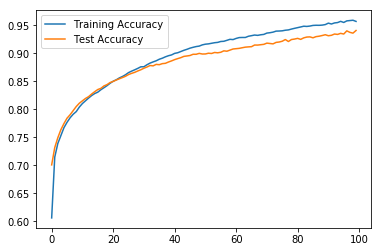

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")

plt.legend()
plt.show()
